In [1]:
import os
import cv2
import itertools
import numpy as np
import splitfolders
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.applications.vgg19 import VGG19
from keras.layers import Input, Lambda, Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator

In [2]:
if not os.path.exists(os.path.join(os.getcwd(), '../output')):
    splitfolders.ratio("../indoorCVPR_09/Images", output="../output", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

In [3]:
folders = glob('../indoorCVPR_09/Images/*')
categories = [folder.split("\\")[-1] for folder in folders]

categories[:5]

['airport_inside', 'auditorium', 'bar', 'bathroom', 'bedroom']

In [4]:
labels = {}
label_no = 0
for category in categories:
    labels[label_no] = category
    label_no += 1

dict(itertools.islice(labels.items(), 10))

{0: 'airport_inside',
 1: 'auditorium',
 2: 'bar',
 3: 'bathroom',
 4: 'bedroom',
 5: 'bookstore',
 6: 'bowling',
 7: 'buffet',
 8: 'casino',
 9: 'children_room'}

In [5]:
vgg19 = VGG19(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
vgg19.trainable = False

In [6]:
flatten_layer = Flatten()
prediction_layer = Dense(len(folders), activation='softmax')

model = Sequential([
    vgg19,
    flatten_layer,
    prediction_layer
])

# view the structure of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 39)                978471    
Total params: 21,002,855
Trainable params: 978,471
Non-trainable params: 20,024,384
_________________________________________________________________


In [7]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
#     shear_range = 0.2,
#     zoom_range = 0.2,
    horizontal_flip = True
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
)

training_set = train_datagen.flow_from_directory(
    '../output/train/',
     target_size=(224, 224),
     batch_size=32,
     class_mode='categorical'
)

validation_set = val_datagen.flow_from_directory(
    '../output/val/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 9024 images belonging to 39 classes.
Found 1114 images belonging to 39 classes.


In [9]:
model.fit(
    training_set,
    validation_data=validation_set,
    epochs=13,
    batch_size=32,
)

Epoch 1/13
282/282 [==============================] - 258s 878ms/step - loss: 2.2211 - accuracy: 0.4510 - val_loss: 1.7063 - val_accuracy: 0.5476
Epoch 2/13
282/282 [==============================] - 209s 741ms/step - loss: 1.0860 - accuracy: 0.6969 - val_loss: 1.6785 - val_accuracy: 0.5583
Epoch 3/13
282/282 [==============================] - 216s 765ms/step - loss: 0.7661 - accuracy: 0.7767 - val_loss: 1.6953 - val_accuracy: 0.5943
Epoch 4/13
282/282 [==============================] - 209s 743ms/step - loss: 0.5174 - accuracy: 0.8466 - val_loss: 1.6008 - val_accuracy: 0.5952
Epoch 5/13
282/282 [==============================] - 178s 633ms/step - loss: 0.4048 - accuracy: 0.8820 - val_loss: 1.5800 - val_accuracy: 0.6203
Epoch 6/13
282/282 [==============================] - 127s 449ms/step - loss: 0.2946 - accuracy: 0.9091 - val_loss: 1.7454 - val_accuracy: 0.6041
Epoch 7/13
282/282 [==============================] - 121s 429ms/step - loss: 0.2401 - accuracy: 0.9263 - val_loss: 1.6337 -

In [10]:
model.save("model.h5")

In [11]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_set = test_datagen.flow_from_directory(
    '../output/test/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1163 images belonging to 39 classes.


In [12]:
model.evaluate(test_set)

37/37 [==============================] - 29s 803ms/step - loss: 2.6318 - accuracy: 0.5847


[2.631765127182007, 0.5846947431564331]

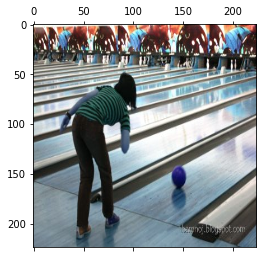

In [13]:
img = cv2.imread(r"../output/test/bowling/bowling_0028.jpg")
img = cv2.resize(img, (224, 224))

plt.matshow(img)

In [14]:
img = img / 255.0

In [15]:
y_pred = model.predict(np.array([img]))

In [16]:
scene = labels[np.argmax(y_pred.flatten())]
scene

'bowling'